In [3]:
import numpy as np
import pandas as pd
import re
from tqdm import tqdm

In [3]:
data = pd.read_csv('X_data_dis.plnd1.csv')
data.head()

,EMPI,Report_Text,hospital_rp,date
0,100003956,accession number: s02k17074 report status: fin...,MGH,2002-03-29
1,100006532,accession number: s9905462c report status: fin...,BWH,1999-02-27
2,100006636,accession number: bs05e05528 report status: fi...,BWH,2005-02-10
3,100001308,accession number: s9935420s report status: fin...,BWH,1999-12-17
4,100093404,accession number: s99t17262 report status: fin...,MGH,1999-04-14


In [4]:
big = pd.read_csv('labs_cl.csv')
big.shape

(602837, 10)

In [7]:
single = pd.read_csv('singlerp.csv')
single.EMPI.nunique(), single.shape

(16768, (16768, 5))

In [ ]:
print(big.EMPI.shape)
big_total = big[big["Total PSA"]]
big_total = big_total.dropna(subset=['time_lab_result'])
print(big_total.shape)


In [ ]:
total_agg = big_total.sort_values('time_lab_result').groupby("EMPI").tail(1)
total_agg.loc[total_agg['EMPI']==100241055]                                        

In [ ]:
print(data.shape)
joint = data.merge(total_agg[['EMPI', 'time_lab_result', 'PSA']], on='EMPI', how='left')
print("number of patients that don't have PSAs from cls files", joint.PSA.isna().sum())
joint = joint.dropna(subset = ["time_lab_result"])
print(joint.shape)

In [ ]:
joint['time_lab_result'] = pd.to_datetime(joint.time_lab_result)
joint['date'] = pd.to_datetime(joint.date)
joint['timely'] = (joint['time_lab_result'] - joint['date']).dt.days > 180 
print("number of patients that don't have PSAs within 180 days of their procedure", joint["timely"].sum())
valid = joint[~joint['timely']]
print(valid.shape)

In [ ]:
all_psa = pd.read_csv('df_psa_result_total_v1.csv')
all_psa.columns

In [ ]:
all_psa['time_lab_result'] = all_psa['date']
agg1 = all_psa.sort_values('time_lab_result').groupby("empi").tail(1)
print(data.shape)

joint = data.merge(agg1[['empi', 'time_lab_result', 'psa_val']], left_on='EMPI',right_on='empi', how='left')
print("number of patients that don't have PSAs from df_psa_result_total_v1.csv file", joint.psa_val.isna().sum())
joint = joint.dropna(subset = ["psa_val"])
print(joint.shape)

joint['time_lab_result'] = pd.to_datetime(joint.time_lab_result)
joint['date'] = pd.to_datetime(joint.date)
joint['timely'] = (joint['time_lab_result'] - joint['date']).dt.days > 180 
print("number of patients that don't have PSAs within 180 days of their procedure", joint["timely"].sum())
valid = joint[~joint['timely']]
print(valid.shape)

In [ ]:
total_agg = big_total.groupby("EMPI")['PSA'].apply(list).reset_index(name='psa_vals')
print(total_agg)
total_agg['date'] = total_agg.merge(big[['EMPI', 'time_lab_result']], on='EMPI', how='left')
total_agg.shape

In [ ]:
big[big.EMPI == 100000079]

## EXTRACTING PRGs

In [45]:
%%time
prg_first = pd.read_csv('/home/jovyan/madhur/reports/g_1.csv', sep="|", low_memory=False)
prg2 = pd.read_csv('/home/jovyan/madhur/reports/g_2.csv', sep="|", low_memory=False)
prg3 = pd.read_csv('/home/jovyan/madhur/reports/g_3.csv', sep="|", low_memory=False)
prg4 = pd.read_csv('/home/jovyan/madhur/reports/g_2.csv', sep="|", low_memory=False)
prg_first = pd.concat([prg_first, prg2, prg3, prg4], ignore_index=True)
prg_first['EMPI'] = np.int64(prg_first['EMPI'])
prg_first['date_report'] = pd.to_datetime(prg_first['Report_Date_Time'], infer_datetime_format=True)

CPU times: user 28.2 s, sys: 2.28 s, total: 30.5 s
Wall time: 33.7 s


In [ ]:
X = pd.read_csv('X_data.csv')
X.info()

In [ ]:
X['date_rp'] = pd.to_datetime(X['date'], infer_datetime_format=True)

In [ ]:
print(X.shape)
dfnew = prg_first.merge(X, left_on='EMPI', right_on='EMPI', how='inner') 
print("matches between X and progress notes", len(dfnew))

In [ ]:
dfnew['daysdiffprgrp'] = (dfnew['date_report'] - dfnew['date_rp']).dt.days

In [ ]:
pd.set_option('display.max_colwidth', None) 

In [ ]:
prgrp_6months = dfnew[(dfnew['daysdiffprgrp'] >= -180) & (dfnew['daysdiffprgrp'] <= -1)]
psarp_6mo = prgrp_6months.sort_values(by=['EMPI', 'daysdiffprgrp'])
# keeping lab closest to RP
nodup_psarp = psarp_6mo.drop_duplicates(subset=['EMPI'], keep='last')
print(len(dfnew)-len(prgrp_6months))
print(len(prgrp_6months))
print(len(nodup_psarp))
# prgrp_6months.head(1)

In [ ]:
prgrp_1year = dfnew[(dfnew['daysdiffprgrp'] >= -365) & (dfnew['daysdiffprgrp'] <= -1)]
psarp_1yr = prgrp_1year.sort_values(by=['EMPI', 'daysdiffprgrp'])
# keeping lab closest to RP
nodup_psarp_1yr = psarp_1yr.drop_duplicates(subset=['EMPI'], keep='last')
print(len(dfnew)-len(prgrp_1year))
print(len(psarp_1yr))
print(len(nodup_psarp_1yr))
# prgrp_6months.head(1)

In [ ]:
dfnew['daysdiffprgrp'] = (dfnew['date_report'] - dfnew['date_rp']).dt.days
dfnew.info()

In [ ]:
%%time
prgrp_6months["Report_Text_y"] = prgrp_6months["Report_Text_y"].str.lower()

In [ ]:
keep_terms = ['psa', ]

In [ ]:
%%time
prg_psa_sens = prgrp_1year[~prgrp_1year['Report_Text_y'].str.contains('|'.join(keep_terms), case=False)] 
#prostate_path2 = prostate_path[~prostate_path['Report_Text'].str.contains('|'.join(remove_terms), case=False)]
print(len(prgrp_6months), 'reports in prg_first from patients without a PSA within 6 months prior to surgery')
print(len(prg_psa_sens), 'reports from', len(prg_psa_sens.drop_duplicates(subset=['EMPI'], keep='first')), 'unique patients with the string "psa" \n in patients without a PSA within 6 months prior to surgery')

In [78]:
np.random.seed()
N_cases = 25
N = len(prg_psa_sens)

prg_psa_sens[[#'date_report', 'daysdiffprgrp', 
             'date_rp', 'Report_Text_y']].iloc[[0,1]]

NameError: name 'prg_psa_sens' is not defined

In [ ]:
prg_psa_sens.columns

In [ ]:
prgrp_1year['contains_psa'] = np.where(prgrp_1year['Report_Text_y'].str.contains('|'.join(keep_terms), case=False), 1, 0)

In [ ]:
# prgrp_1year['date'] = pd.to_datetime(joint.date)
prgrp_1year['date_rp']

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
prgrp_1year['date_rp'].hist(by=prgrp_1year['contains_psa'], ax=ax)


In [ ]:
n0 = pd.read_csv('n0_EMPI_220422.csv', sep='\t', index_col=None)
n1 = pd.read_csv('n1_EMPI_220422.csv', sep='\t', index_col=None)
labelled_empis = pd.concat([n0, n1])
labelled_empis.head()

In [ ]:
print(valid.shape)
print(labelled_empis.shape)
final_ids = labelled_empis.merge(valid, on='EMPI', how='inner')
print(final_ids.shape)

In [ ]:
lab1 = pd.read_csv('lab1.csv')
lab2 = pd.read_csv('lab2.csv')
lab3 = pd.read_csv('lab3.csv', skiprows=[26279])
lab4 = pd.read_csv('lab4.csv')
lab_all = pd.concat([lab1, lab2, lab3, lab4], ignore_index=True)
lab_all.shape

In [ ]:
lab3 = pd.read_csv('lab3.csv', skiprows=[26279])

## From the top

In [ ]:
n0 = pd.read_csv('n0_EMPI_220422.csv', sep='\t', index_col=None)
n1 = pd.read_csv('n1_EMPI_220422.csv', sep='\t', index_col=None)
n0['label'] = 0
n1['label'] = 1
labelled_empis = pd.concat([n0, n1])
labelled_empis.drop_duplicates(subset=['EMPI'], inplace=True)
print(labelled_empis.shape, labelled_empis.EMPI.nunique())


In [399]:
nocd = pd.read_csv('NOCD.csv', sep='\t')
labelled_empis = nocd.drop_duplicates(subset=['EMPI'])

In [400]:
#now find rp_date
#drop duplicates because duplicate reports have same date, just different 
all_x = pd.read_csv('X_data.csv')
print(all_x.shape, all_x.EMPI.nunique())
all_x.drop_duplicates(subset=['EMPI'], inplace=True)
print(all_x.shape)

(16656, 4) 16494
(16494, 4)


In [401]:
print(labelled_empis.EMPI.nunique())
dated_rp = labelled_empis.merge(all_x[['EMPI', 'date']], on='EMPI', how='inner')
print(labelled_empis.shape, dated_rp.shape)
print(dated_rp.EMPI.nunique())
print(dated_rp.date.isna().sum())

3573
(3573, 25) (3542, 26)
3542
0


In [412]:
dated_rp.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'EMPI', 'EPIC_PMRN', 'MRN_Type', 'MRN',
       'Report_Number', 'Report_Date_Time', 'Report_Description',
       'Report_Status', 'Report_Type', 'Report_Text', 'num_pos_cores',
       'primary_grade', 'secondary_grade', 'overall_grade_group',
       'radical_prostatectomy', 'small_cell_carc', 'neuroendocrine_carc',
       'adenocarcinoma', 'margin', 'pT_stage', 'pT_stage_context',
       'pT_stage_combined', 'NOCD', 'date'],
      dtype='object')

In [402]:
psas = pd.read_csv('labs_cl.csv')
print(psas.columns)
psa_total = psas[psas["Total PSA"]]
psa_total = psa_total.dropna(subset=['time_lab_result'])

Index(['EMPI', 'time_lab_result', 'lab_group', 'PSA', 'undetect', 'greater',
       'Percent Free', 'Total PSA', 'lab_result', 'lab_result_txt'],
      dtype='object')


In [403]:
# unique_psa = psa_total.sort_values('time_lab_result').groupby("EMPI").tail(1)
# unique_psa.shape

In [404]:
print(labelled_empis.shape, psa_total.shape)
psas_with_labels = psa_total.merge(dated_rp, on="EMPI", how='inner')
psas_with_labels.shape

(3573, 25) (517014, 10)


(28912, 35)

In [405]:
psas_with_labels.columns

Index(['EMPI', 'time_lab_result', 'lab_group', 'PSA', 'undetect', 'greater',
       'Percent Free', 'Total PSA', 'lab_result', 'lab_result_txt',
       'Unnamed: 0', 'Unnamed: 0.1', 'EPIC_PMRN', 'MRN_Type', 'MRN',
       'Report_Number', 'Report_Date_Time', 'Report_Description',
       'Report_Status', 'Report_Type', 'Report_Text', 'num_pos_cores',
       'primary_grade', 'secondary_grade', 'overall_grade_group',
       'radical_prostatectomy', 'small_cell_carc', 'neuroendocrine_carc',
       'adenocarcinoma', 'margin', 'pT_stage', 'pT_stage_context',
       'pT_stage_combined', 'NOCD', 'date'],
      dtype='object')

In [406]:
psas_with_labels['time_lab_result'] = pd.to_datetime(psas_with_labels.time_lab_result)
psas_with_labels['date'] = pd.to_datetime(psas_with_labels.date)
psas_with_labels['days_diff'] = psas_with_labels['date'] - psas_with_labels['time_lab_result']
psas_with_labels['timely'] = ((psas_with_labels['days_diff']).dt.days > 0) &  ((psas_with_labels['days_diff']).dt.days < 180 )
print("number of patients that don't have PSAs within 180 days of their procedure", psas_with_labels.shape[0] - psas_with_labels["timely"].sum())
valid = psas_with_labels[psas_with_labels['timely']]
print(valid.shape)

number of patients that don't have PSAs within 180 days of their procedure 26604
(2308, 37)


In [407]:
valid.EMPI.nunique()

1727

In [408]:
valid.head()

,EMPI,time_lab_result,lab_group,PSA,undetect,greater,Percent Free,Total PSA,lab_result,lab_result_txt,...,neuroendocrine_carc,adenocarcinoma,margin,pT_stage,pT_stage_context,pT_stage_combined,NOCD,date,days_diff,timely
8,100003956,2001-10-29 10:37:00,PSA (Total and Screening),8.48,False,False,False,True,8.48,NaN,...,0,1,0.0,pt2,pt2,pt2,0,2002-03-29,150 days 13:23:00,True
52,100006532,1998-10-20 11:35:00,PSA (Total and Screening),3.30,False,False,False,True,3.3,NaN,...,0,1,0.0,pt2b,NaN,pt2b,0,1999-02-27,129 days 12:25:00,True
72,100006636,2004-11-16 12:02:00,PSA (Total and Screening),5.30,False,False,False,True,5.3,"DONE AT BWH CLIN LABS, BOSTON",...,0,1,0.0,pt2c,NaN,pt2c,0,2005-02-10,85 days 11:58:00,True
103,100001308,1999-08-18 09:11:00,PSA (Total and Screening),4.70,False,False,False,True,4.7,"DONE AT BWH CLIN LABS, BOSTON",...,0,1,0.0,pt2b,NaN,pt2b,0,1999-12-17,120 days 14:49:00,True
113,100095964,2004-05-18 15:10:00,PSA (Total and Screening),5.20,False,False,False,True,5.2,"Reference range: 0.0 to 4.0 Performed at QUEST NICHOLS, 14225 Newbrook Drive, Chantilly, VA 20153",...,0,1,0.0,pt2,pt2,pt2,0,2004-06-02,14 days 08:50:00,True


In [409]:
valid = valid.sort_values(by=['EMPI', 'days_diff'])
# keeping lab closest to RP
nodup_valid = valid.drop_duplicates(subset=['EMPI'], keep='last')

In [413]:
nodup_valid.NOCD.sum()

418

In [395]:
nodup_valid.to_csv("cohort_psa.csv")

In [ ]:
valid.label.sum()

In [ ]:
valid.EMPI.nunique()

In [ ]:
n1.shape

## For wayne

In [78]:
singlerp = pd.read_csv('singlerp.csv')
singlerp.columns

Index(['EMPI', 'date_rp', 'hospital_rp', 'lap_rp', 'lymph_rp'], dtype='object')

In [79]:
psas = pd.read_csv('labs_cl.csv')
print(psas.columns)
psa_total = psas[psas["Total PSA"]]
psa_total = psa_total.dropna(subset=['time_lab_result'])

Index(['EMPI', 'time_lab_result', 'lab_group', 'PSA', 'undetect', 'greater',
       'Percent Free', 'Total PSA', 'lab_result', 'lab_result_txt'],
      dtype='object')


In [ ]:
p

In [80]:
print(singlerp.shape, psa_total.shape)
psas_with_text = psa_total.merge(singlerp, on="EMPI", how="right")
psas_with_text.shape


(16768, 5) (517014, 10)


(147629, 14)

In [81]:
psas_with_text.columns

Index(['EMPI', 'time_lab_result', 'lab_group', 'PSA', 'undetect', 'greater',
       'Percent Free', 'Total PSA', 'lab_result', 'lab_result_txt', 'date_rp',
       'hospital_rp', 'lap_rp', 'lymph_rp'],
      dtype='object')

In [82]:
psa_total["PSA"].isna().sum(), psa_total.shape

(1770, (517014, 10))

In [83]:
psas_with_text['time_lab_result'] = pd.to_datetime(psas_with_text.time_lab_result)
psas_with_text['date_rp'] = pd.to_datetime(psas_with_text.date_rp)
psas_with_text['days_diff'] = psas_with_text['date_rp'] - psas_with_text['time_lab_result']
psas_with_text['timely'] = ((psas_with_text['days_diff']).dt.days > 0) &  ((psas_with_text['days_diff']).dt.days < 180 )
print("number of patients that don't have PSAs within 180 days of their procedure", psas_with_text.shape[0] - psas_with_text["timely"].sum())
valid_text = psas_with_text[psas_with_text['timely']]
print(valid_text.shape)

number of patients that don't have PSAs within 180 days of their procedure 137180
(10449, 16)


In [84]:
valid_text.EMPI.nunique()

7685

In [85]:
psas_with_text.shape, psas_with_text.lab_result_txt.isna().sum()

((147629, 16), 50418)

In [98]:
psas_with_text_doc = psas_with_text[~psas_with_text.lab_result_txt.isna()]

In [99]:
psas_with_text_doc.columns

Index(['EMPI', 'time_lab_result', 'lab_group', 'PSA', 'undetect', 'greater',
       'Percent Free', 'Total PSA', 'lab_result', 'lab_result_txt', 'date_rp',
       'hospital_rp', 'lap_rp', 'lymph_rp', 'days_diff', 'timely'],
      dtype='object')

In [50]:
total_overlap_patients_with_doc = singlerp.merge(psas_with_text_doc, on="EMPI", how="inner")
total_overlap_patients_with_doc.shape

(97211, 20)

In [51]:
total_overlap_patients_with_doc.EMPI.nunique()

12138

In [52]:
total_overlap_patients_with_doc["Total PSA"].isna().sum()

0

In [87]:
%%time
prg_first = pd.read_csv('/home/jovyan/madhur/reports/g_1.csv', sep="|", low_memory=False)
prg2 = pd.read_csv('/home/jovyan/madhur/reports/g_2.csv', sep="|", low_memory=False)
prg3 = pd.read_csv('/home/jovyan/madhur/reports/g_3.csv', sep="|", low_memory=False)
prg4 = pd.read_csv('/home/jovyan/madhur/reports/g_2.csv', sep="|", low_memory=False)
prg_first = pd.concat([prg_first, prg2, prg3, prg4], ignore_index=True)
prg_first['EMPI'] = np.int64(prg_first['EMPI'])
prg_first['date_report'] = pd.to_datetime(prg_first['Report_Date_Time'], infer_datetime_format=True)

CPU times: user 23 s, sys: 947 ms, total: 24 s
Wall time: 24 s


In [88]:
singlerp_w_prg = singlerp.merge(prg_first, on="EMPI", how="inner")
singlerp_w_prg.EMPI.nunique()

1130

In [89]:
singlerp_w_prg.shape

(48153, 15)

In [90]:
inference_rp = singlerp_w_prg[~singlerp_w_prg.EMPI.isin(total_overlap_patients_with_doc.EMPI)]

In [91]:
inference_rp.EMPI.nunique()

187

In [92]:
inference_rp.columns

Index(['EMPI', 'date_rp', 'hospital_rp', 'lap_rp', 'lymph_rp', 'EPIC_PMRN',
       'MRN_Type', 'MRN', 'Report_Number', 'Report_Date_Time',
       'Report_Description', 'Report_Status', 'Report_Type', 'Report_Text',
       'date_report'],
      dtype='object')

In [93]:
inference_rp.date_rp = pd.to_datetime(inference_rp.date_rp)
inference_rp['daysdiff'] = inference_rp.date_rp - inference_rp.date_report
inference_rp['timely'] = ((inference_rp['daysdiff']).dt.days > 0) &  ((inference_rp['daysdiff']).dt.days < 180 )
inference_rp[inference_rp["timely"]].EMPI.nunique()

/opt/conda/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/tmp/ipykernel_1424/18200774.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inference_rp['daysdiff'] = inference_rp.date_rp - inference_rp.date_report
/tmp/ipykernel_1424/18200774.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

55

In [96]:
rp_no_psa = psas_with_text[~psas_with_text['timely']]

In [97]:
rp_no_psa.shape

(137180, 16)

In [62]:
rp_no_psa_prg = rp_no_psa.merge(prg_first, on="EMPI", how="inner")
rp_no_psa_prg.EMPI.nunique()

1074

In [63]:
inference_rp = rp_no_psa_prg 
inference_rp.date_rp = pd.to_datetime(inference_rp.date_rp)
inference_rp['daysdiff'] = inference_rp.date_rp - inference_rp.date_report
inference_rp['timely'] = ((inference_rp['daysdiff']).dt.days > 0) &  ((inference_rp['daysdiff']).dt.days < 180 )
inference_rp[inference_rp["timely"]].EMPI.nunique()

299

In [66]:
test_rps = inference_rp[inference_rp["timely"]]

In [69]:
test_rps.columns

Index(['EMPI', 'time_lab_result', 'lab_group', 'PSA', 'undetect', 'greater',
       'Percent Free', 'Total PSA', 'lab_result', 'lab_result_txt', 'date_rp',
       'hospital_rp', 'lap_rp', 'lymph_rp', 'days_diff', 'timely', 'EPIC_PMRN',
       'MRN_Type', 'MRN', 'Report_Number', 'Report_Date_Time',
       'Report_Description', 'Report_Status', 'Report_Type', 'Report_Text',
       'date_report', 'daysdiff'],
      dtype='object')

In [70]:
test_rps.drop(columns=['lab_group', 'undetect', 'greater', 'Percent Free', 'lab_result_txt', 'daysdiff', 'date_report'])

,EMPI,time_lab_result,PSA,Total PSA,lab_result,date_rp,hospital_rp,lap_rp,lymph_rp,days_diff,timely,EPIC_PMRN,MRN_Type,MRN,Report_Number,Report_Date_Time,Report_Description,Report_Status,Report_Type,Report_Text
3,100126964,2018-04-12 09:50:00,6.30,True,6.3,2019-03-25,MGH,1,0,346 days 14:10:00,True,10045993481,MGH,1387115,2291733168,1/15/2019 11:00:00 AM,MPRGPROGRESS,F,MPRGPROGRESS,***This text report has been converted from t...
4,100126964,2018-04-12 09:50:00,6.30,True,6.3,2019-03-25,MGH,1,0,346 days 14:10:00,True,10045993481,MGH,1387115,2260215367,12/19/2018 11:00:00 AM,MPRGPROGRESS,F,MPRGPROGRESS,***This text report has been converted from t...
5,100126964,2018-04-12 09:50:00,6.30,True,6.3,2019-03-25,MGH,1,0,346 days 14:10:00,True,10045993481,MGH,1387115,2249841213,12/11/2018 10:15:00 AM,MPRGPROGRESS,F,MPRGPROGRESS,***This text report has been converted from t...
12,100126964,2018-04-12 09:50:00,6.30,True,6.3,2019-03-25,MGH,1,0,346 days 14:10:00,True,10045993481,MGH,1387115,2376200393,3/19/2019 1:10:00 PM,MPRGPROGRESS,F,MPRGPROGRESS,***This text report has been converted from t...
13,100126964,2018-04-12 09:50:00,6.30,True,6.3,2019-03-25,MGH,1,0,346 days 14:10:00,True,10045993481,MGH,1387115,2305422190,1/25/2019 10:00:00 AM,MPRGPROGRESS,F,MPRGPROGRESS,***This text report has been converted from t...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803773,107101524,2019-05-08 13:53:00,0.31,True,0.31,2019-04-01,FH,1,1,-38 days +10:07:00,True,10062720379,BWH,39118955,2368136828,3/13/2019 5:20:00 PM,BPRGPROGRESS,F,BPRGPROGRESS,***This text report has been converted from t...
803787,107088372,2015-02-13 10:16:00,0.35,True,0.35,2016-06-22,BWH,0,0,494 days 13:44:00,True,10022660020,BWH,31655624,852905923,2/2/2016 4:00:40 PM,BPRGPROGRESS,F,BPRGPROGRESS,***This text report has been converted from t...
803788,107088372,2015-02-13 10:16:00,0.35,True,0.35,2016-06-22,BWH,0,0,494 days 13:44:00,True,10022660020,BWH,31655624,759783576,1/13/2016 4:58:17 PM,BPRGPeriop Nursi,F,BPRGPeriop Nursi,***This text report has been converted from t...
803789,107088372,2015-02-13 10:16:00,0.35,True,0.35,2016-06-22,BWH,0,0,494 days 13:44:00,True,10022660020,BWH,31655624,759690741,1/13/2016 3:59:06 PM,BPRGPeriop Nursi,F,BPRGPeriop Nursi,***This text report has been converted from t...


In [71]:
test_rps.to_csv("test_prgs.csv")

In [80]:
prg_first.columns

Index(['EMPI', 'EPIC_PMRN', 'MRN_Type', 'MRN', 'Report_Number',
       'Report_Date_Time', 'Report_Description', 'Report_Status',
       'Report_Type', 'Report_Text', 'date_report'],
      dtype='object')

In [22]:
keep_terms=['psa',]

In [ ]:
%%time
prg_w_psa = prg_first[prg_first['Report_Text'].str.contains('|'.join(keep_terms), case=False)] 
prg_w_psa.shape

In [ ]:
prg_w_both = prg_w_psa.merge(psa_total, on="EMPI")
prg_w_both.shape

In [31]:
prg_w_both.Report_Date_Time_x = pd.to_datetime(prg_w_both.Report_Date_Time)
prg_w_both['daysdiff'] = prg_w_both.Report_Date_Time_x - prg_w_both.date_report
prg_w_both['match'] = ((prg_w_both['daysdiff']).dt.days < 1 ) &  ((prg_w_both['daysdiff']).dt.days > -1 )
prg_w_both[prg_w_both["match"]].EMPI.nunique()

2707

In [32]:
prg_w_both.shape

(606426, 22)

In [35]:
prg_w_both.EMPI.value_counts()

102971179    7140
105752955    5368
106994523    5236
100234244    5110
107700539    4980
             ... 
109051868       1
100923867       1
105409988       1
100145899       1
102050171       1
Name: EMPI, Length: 2707, dtype: int64

In [37]:
prg_w_both.columns

Index(['EMPI', 'EPIC_PMRN', 'MRN_Type', 'MRN', 'Report_Number',
       'Report_Date_Time', 'Report_Description', 'Report_Status',
       'Report_Type', 'Report_Text', 'date_report', 'time_lab_result',
       'lab_group', 'PSA', 'undetect', 'greater', 'Percent Free', 'Total PSA',
       'lab_result', 'lab_result_txt', 'daysdiff', 'match'],
      dtype='object')

In [38]:
prg_w_psa.columns, psa_total.columns
# sample = prg_w_psa.merge(psa_total, on=["EMPI", )

(Index(['EMPI', 'EPIC_PMRN', 'MRN_Type', 'MRN', 'Report_Number',
        'Report_Date_Time', 'Report_Description', 'Report_Status',
        'Report_Type', 'Report_Text', 'date_report'],
       dtype='object'),
 Index(['EMPI', 'time_lab_result', 'lab_group', 'PSA', 'undetect', 'greater',
        'Percent Free', 'Total PSA', 'lab_result', 'lab_result_txt'],
       dtype='object'))

In [39]:
prg_w_psa.to_csv("train_prgs.csv")

In [40]:
inference_rp.d

EMPI                            int64
time_lab_result        datetime64[ns]
lab_group                      object
PSA                           float64
undetect                       object
greater                        object
Percent Free                   object
Total PSA                      object
lab_result                     object
lab_result_txt                 object
date_rp                datetime64[ns]
hospital_rp                    object
lap_rp                          int64
lymph_rp                        int64
days_diff             timedelta64[ns]
timely                           bool
EPIC_PMRN                       int64
MRN_Type                       object
MRN                             int64
Report_Number                  object
Report_Date_Time               object
Report_Description             object
Report_Status                  object
Report_Type                    object
Report_Text                    object
date_report            datetime64[ns]
daysdiff    

## For wayne part 2

In [111]:
%%time
prg_first = pd.read_csv('/home/jovyan/madhur/reports/g_1.csv', sep="|", low_memory=False)
prg2 = pd.read_csv('/home/jovyan/madhur/reports/g_2.csv', sep="|", low_memory=False)
prg3 = pd.read_csv('/home/jovyan/madhur/reports/g_3.csv', sep="|", low_memory=False)
prg4 = pd.read_csv('/home/jovyan/madhur/reports/g_2.csv', sep="|", low_memory=False)
prg_first = pd.concat([prg_first, prg2, prg3, prg4], ignore_index=True)
prg_first['EMPI'] = np.int64(prg_first['EMPI'])
prg_first['date_report'] = pd.to_datetime(prg_first['Report_Date_Time'], infer_datetime_format=True)

CPU times: user 23.2 s, sys: 1.18 s, total: 24.4 s
Wall time: 24.4 s


In [112]:
psas = pd.read_csv('labs_cl.csv')
print(psas.columns)
psa_total = psas[psas["Total PSA"]]
psa_total = psa_total.dropna(subset=['time_lab_result'])

Index(['EMPI', 'time_lab_result', 'lab_group', 'PSA', 'undetect', 'greater',
       'Percent Free', 'Total PSA', 'lab_result', 'lab_result_txt'],
      dtype='object')


In [113]:
singlerp = pd.read_csv('singlerp.csv')
singlerp.columns

Index(['EMPI', 'date_rp', 'hospital_rp', 'lap_rp', 'lymph_rp'], dtype='object')

In [114]:
rp_with_psa = singlerp.merge(psa_total, on="EMPI", how="right")
rp_with_psa.columns

Index(['EMPI', 'date_rp', 'hospital_rp', 'lap_rp', 'lymph_rp',
       'time_lab_result', 'lab_group', 'PSA', 'undetect', 'greater',
       'Percent Free', 'Total PSA', 'lab_result', 'lab_result_txt'],
      dtype='object')

In [115]:
#which of these psas are valid, which of these patients need psas from prg reports?
rp_with_psa['time_lab_result'] = pd.to_datetime(rp_with_psa.time_lab_result)
rp_with_psa['date_rp'] = pd.to_datetime(rp_with_psa.date_rp)
rp_with_psa['days_diff'] = rp_with_psa['date_rp'] - rp_with_psa['time_lab_result']
rp_with_psa['timely'] = ((rp_with_psa['days_diff']).dt.days > 0) &  ((rp_with_psa['days_diff']).dt.days < 180 )
print("number of patients that don't have PSAs within 180 days of their procedure", rp_with_psa.shape[0] - rp_with_psa["timely"].sum())
valid_psa = rp_with_psa[rp_with_psa['timely']]
# need_psa = rp_with_psa[~rp_with_psa['timely']]
need_psa = singlerp[~singlerp.EMPI.isin(valid_psa.EMPI)]
print(valid_psa.shape)

number of patients that don't have PSAs within 180 days of their procedure 506565
(10449, 16)


In [120]:
test_prgs["useful_prg"] = ((test_prgs['days_surg_to_prg']).dt.days < 180 ) &  ((test_prgs['days_surg_to_prg']).dt.days > 0 )

In [123]:
#get prgs for those that need psa values to be predicted from their prg reports

test_prgs = need_psa.merge(prg_first, on=["EMPI"])
test_prgs.date_rp = pd.to_datetime(test_prgs.date_rp)
test_prgs["days_surg_to_prg"] = test_prgs.date_rp - test_prgs.date_report
test_prgs["useful_prg"] = ((test_prgs['days_surg_to_prg']).dt.days < 180 ) &  ((test_prgs['days_surg_to_prg']).dt.days > 0 )
print(test_prgs.shape, test_prgs.useful_prg.sum())
prgs_to_get_valid_psa = test_prgs[test_prgs.useful_prg]
prgs_to_get_valid_psa.shape

(19428, 17) 1046


(1046, 17)

In [155]:
#inference, test set
prgs_to_get_valid_psa.to_csv("prgs_to_get_psa.csv")

In [153]:
prgs_to_get_valid_psa.shape

(1046, 17)

In [130]:
psa_total.dtypes, "**", prg_first.dtypes

(EMPI                 int64
 time_lab_result     object
 lab_group           object
 PSA                float64
 undetect              bool
 greater               bool
 Percent Free          bool
 Total PSA             bool
 lab_result          object
 lab_result_txt      object
 dtype: object,
 '**',
 EMPI                           int64
 EPIC_PMRN                      int64
 MRN_Type                      object
 MRN                            int64
 Report_Number                 object
 Report_Date_Time              object
 Report_Description            object
 Report_Status                 object
 Report_Type                   object
 Report_Text                   object
 date_report           datetime64[ns]
 dtype: object)

In [135]:
#get prg reports that have psas to use as training set
psa_total["time_lab_result"] = pd.to_datetime(psa_total.time_lab_result)
# time_lab_result
psa_with_prg = psa_total.merge(prg_first, on=["EMPI"])
psa_with_prg.shape, psa_with_prg.columns

((3155691, 21),
 Index(['EMPI', 'time_lab_result', 'lab_group', 'PSA', 'undetect', 'greater',
        'Percent Free', 'Total PSA', 'lab_result', 'lab_result_txt',
        'date_report_x', 'EPIC_PMRN', 'MRN_Type', 'MRN', 'Report_Number',
        'Report_Date_Time', 'Report_Description', 'Report_Status',
        'Report_Type', 'Report_Text', 'date_report_y'],
       dtype='object'))

In [143]:
#find reports that correspond to days when psa was measured
psa_with_prg["days_prg_to_psa"] = psa_with_prg.date_report_y - psa_with_prg.time_lab_result
psa_with_prg["match"] = ((psa_with_prg['days_prg_to_psa']).dt.days < 1 ) &  ((psa_with_prg['days_prg_to_psa']).dt.days > -1 )
matched_prgs = psa_with_prg[psa_with_prg["match"]]
                                         
patients_learning_from = psa_with_prg[psa_with_prg["match"]].EMPI.nunique()
report_learning_from = psa_with_prg["match"].sum()
print("Learning from {} reports across {} patients".format(report_learning_from, patients_learning_from))

Learning from 5534 reports across 1144 patients


In [152]:
#train set of prg notes
# matched_prgs.drop(columns=['lab_group', 'undetect', 'greater', 'Percent Free', 'Total PSA', 'lab_result', 'lab_result_txt', 'date_report_x', 'match', 'date_report_y'])
matched_prgs.to_csv("prgs_with_psas.csv")

In [151]:
matched_prgs.columns

Index(['EMPI', 'time_lab_result', 'lab_group', 'PSA', 'undetect', 'greater',
       'Percent Free', 'Total PSA', 'lab_result', 'lab_result_txt',
       'date_report_x', 'EPIC_PMRN', 'MRN_Type', 'MRN', 'Report_Number',
       'Report_Date_Time', 'Report_Description', 'Report_Status',
       'Report_Type', 'Report_Text', 'date_report_y', 'days_prg_to_psa',
       'match'],
      dtype='object')

In [147]:
matched_prgs.head()

,EMPI,time_lab_result,lab_group,PSA,undetect,greater,Percent Free,Total PSA,lab_result,lab_result_txt,...,MRN,Report_Number,Report_Date_Time,Report_Description,Report_Status,Report_Type,Report_Text,date_report_y,days_prg_to_psa,match
353,100006532,2016-06-22 12:02:00,PSA (Total and Screening),0.009,True,False,False,True,<0.02,"Test Performed By: BWH Clinical Laboratories, ...",...,975151,1100783000,6/22/2016 5:56:53 PM,BPRGPROGRESS,R,BPRGPROGRESS,***This text report has been converted from t...,2016-06-22 17:56:53,0 days 05:54:53,True
2466,100006636,2015-08-13 09:58:00,PSA Monitoring,0.009,True,False,False,True,<0.01,"Test Performed By: BWH Clinical Laboratories, ...",...,984781,553765187,8/13/2015 11:03:03 AM,BPRGPROGRESS,F,BPRGPROGRESS,***This text report has been converted from t...,2015-08-13 11:03:03,0 days 01:05:03,True
5129,100095964,2016-08-17 09:15:00,PSA (Total and Screening),0.009,True,False,False,True,<0.10,Test Performed By: MGH Department of Pathology...,...,3408237,1189924830,8/17/2016 9:22:54 AM,MPRGPROGRESS,F,MPRGPROGRESS,***This text report has been converted from t...,2016-08-17 09:22:54,0 days 00:07:54,True
5130,100095964,2016-08-17 09:15:00,PSA (Total and Screening),0.009,True,False,False,True,<0.10,Test Performed By: MGH Department of Pathology...,...,3408237,1189920526,8/17/2016 9:22:54 AM,MPRGPROGRESS,F,MPRGPROGRESS,***This text report has been converted from t...,2016-08-17 09:22:54,0 days 00:07:54,True
6410,100095964,2019-08-07 15:35:00,PSA Monitoring,0.009,True,False,False,True,<0.10,Post radical prostatectomy results should be <...,...,3408237,2731135496,8/7/2019 4:44:00 PM,MPRGPROGRESS,F,MPRGPROGRESS,***This text report has been converted from t...,2019-08-07 16:44:00,0 days 01:09:00,True


## Modelling

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
import matplotlib

In [15]:
df = pd.read_csv('data_raw.csv')
features = pd.read_csv('all_features.csv')

In [16]:
Xy = df.merge(features, on="EMPI", how="left")
df.shape, Xy.shape

((474, 5), (474, 14))

In [17]:
Xy.drop(columns = ['Unnamed: 0', 'EMPI'], inplace=True) #"score_agg", "wscore_agg"
Xy.rename(columns={'overall_gs_x': 'biop_gleason_max', 'overall_gs_y': 'biop_gleason_avg'}, inplace=True)
Xy

,PSA,label,MRN_Type,P_Score,Age at RP,race_cat,num_pos_cores_sum,ratio_pos_cores,score_agg,wscore_agg,biop_gleason_max,biop_gleason_avg
0,4.00,0,MGH,4.0,74.0,White,4.0,0.666667,3.0,5.0,7.0,7.000000
1,8.87,0,NWH,3.0,58.0,White,NaN,NaN,2.0,3.0,NaN,NaN
2,11.86,0,MGH,5.0,66.0,White,NaN,NaN,1.0,2.0,NaN,NaN
3,8.77,0,NSM,4.0,73.0,White,4.0,0.666667,NaN,NaN,7.0,6.333333
4,13.83,0,MGH,5.0,61.0,White,5.0,0.714286,8.0,11.0,7.0,6.333333
...,...,...,...,...,...,...,...,...,...,...,...,...
469,6.04,0,MGH,4.0,58.0,White,11.0,1.000000,1.0,2.0,6.0,6.000000
470,4.16,0,MGH,5.0,59.0,Unknown/other,NaN,NaN,1.0,2.0,NaN,NaN
471,2.77,0,MGH,4.0,65.0,White,4.0,1.000000,NaN,NaN,7.0,6.250000
472,12.33,0,MGH,5.0,62.0,White,NaN,NaN,1.0,2.0,NaN,NaN


In [18]:
Xy = pd.read_csv("final_all.csv")
Xy.head()

,LN_meta,P_Score,PSA,Age at RP,race_cat,score_agg,wscore_agg,overall_gs_max,overall_gs_avg,pos_core_ratio
0,0.0,NaN,3.3,56.0,Unknown/other,6.0,13.0,7.0,7.0,0.333333
1,0.0,NaN,5.3,50.0,White,3.0,5.0,6.0,6.0,0.333333
2,0.0,NaN,4.7,62.0,White,6.0,8.0,NaN,NaN,NaN
3,0.0,4.0,NaN,72.0,Unknown/other,2.0,3.0,NaN,NaN,NaN
4,0.0,NaN,NaN,56.0,Hispanic,1.0,2.0,6.0,6.0,0.200000


In [19]:
Xy.drop(columns = ['race_cat'], inplace=True)
Xy.isna().sum()

LN_meta              0
P_Score           8377
PSA               8525
Age at RP          115
score_agg         3166
wscore_agg        3166
overall_gs_max    6623
overall_gs_avg    6623
pos_core_ratio    6623
dtype: int64

In [20]:
a = Xy.dropna(subset=["biop_gleason_avg"])
a.isna().sum()

KeyError: ['biop_gleason_avg']

In [292]:
Xy.head()

,LN_meta,P_Score,PSA,Age at RP,race_cat,score_agg,wscore_agg,overall_gs_max,overall_gs_avg,pos_core_ratio
0,0.0,NaN,3.3,56.0,Unknown/other,6.0,13.0,7.0,7.0,0.333333
1,0.0,NaN,5.3,50.0,White,3.0,5.0,6.0,6.0,0.333333
2,0.0,NaN,4.7,62.0,White,6.0,8.0,NaN,NaN,NaN
3,0.0,4.0,NaN,72.0,Unknown/other,2.0,3.0,NaN,NaN,NaN
4,0.0,NaN,NaN,56.0,Hispanic,1.0,2.0,6.0,6.0,0.200000


In [293]:
Xy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11114 entries, 0 to 11113
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   LN_meta         11114 non-null  float64
 1   P_Score         2737 non-null   float64
 2   PSA             2589 non-null   float64
 3   Age at RP       10999 non-null  float64
 4   race_cat        10999 non-null  object 
 5   score_agg       7948 non-null   float64
 6   wscore_agg      7948 non-null   float64
 7   overall_gs_max  4491 non-null   float64
 8   overall_gs_avg  4491 non-null   float64
 9   pos_core_ratio  4491 non-null   float64
dtypes: float64(9), object(1)
memory usage: 868.4+ KB


/tmp/ipykernel_3437/377705901.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  Xy.hist(ax=ax)


array([[<AxesSubplot:title={'center':'LN_meta'}>,
        <AxesSubplot:title={'center':'P_Score'}>,
        <AxesSubplot:title={'center':'PSA'}>],
       [<AxesSubplot:title={'center':'Age at RP'}>,
        <AxesSubplot:title={'center':'score_agg'}>,
        <AxesSubplot:title={'center':'wscore_agg'}>],
       [<AxesSubplot:title={'center':'overall_gs_max'}>,
        <AxesSubplot:title={'center':'overall_gs_avg'}>,
        <AxesSubplot:title={'center':'pos_core_ratio'}>]], dtype=object)

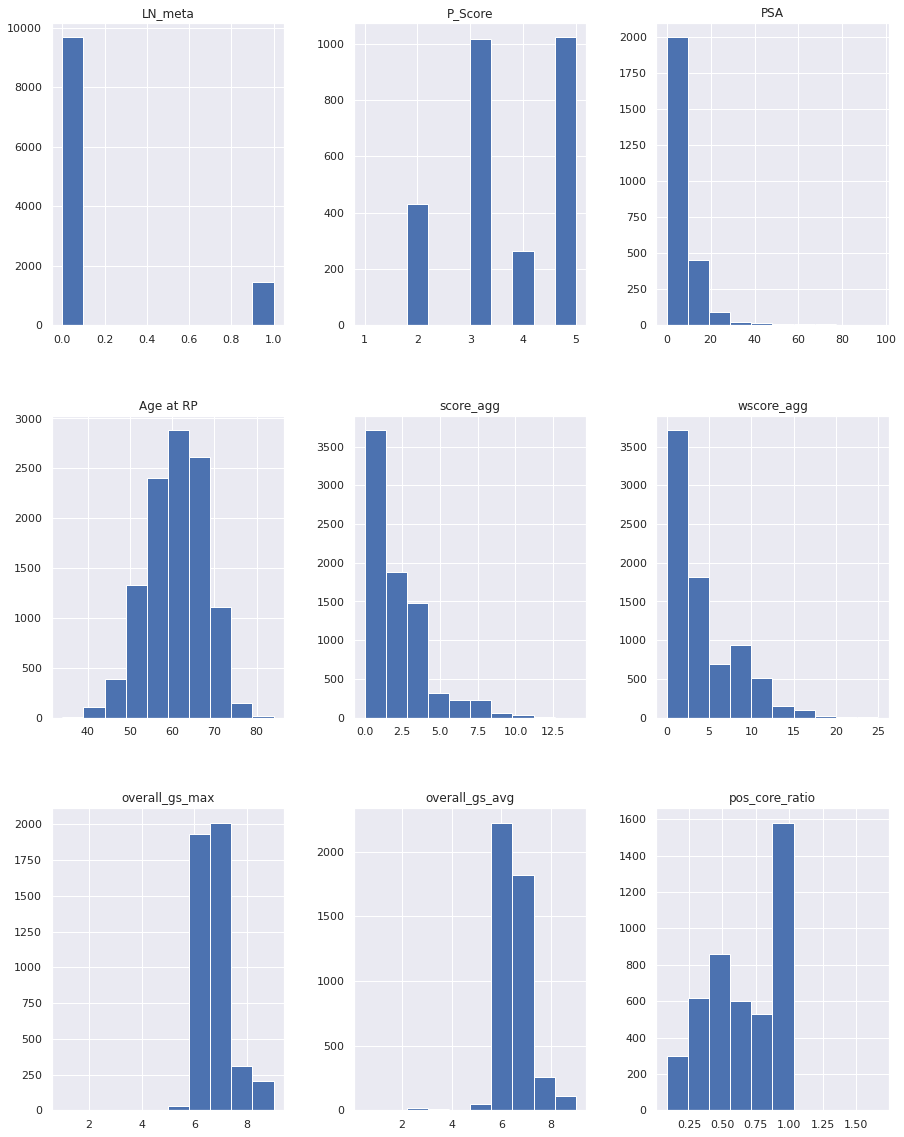

In [21]:
#check distribution of each feature
fig = plt.figure(figsize=(15,20))
ax = fig.gca()
Xy.hist(ax=ax)

<AxesSubplot:>

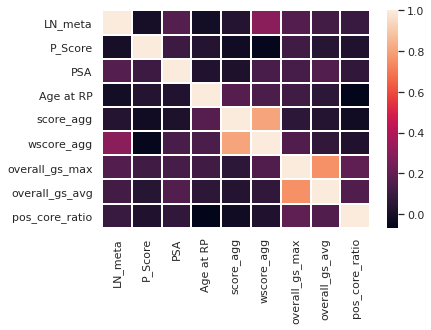

In [25]:
#check for correlations between features
df_corr = Xy_filtered.corr()
sns.heatmap(df_corr, linewidths=1)

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


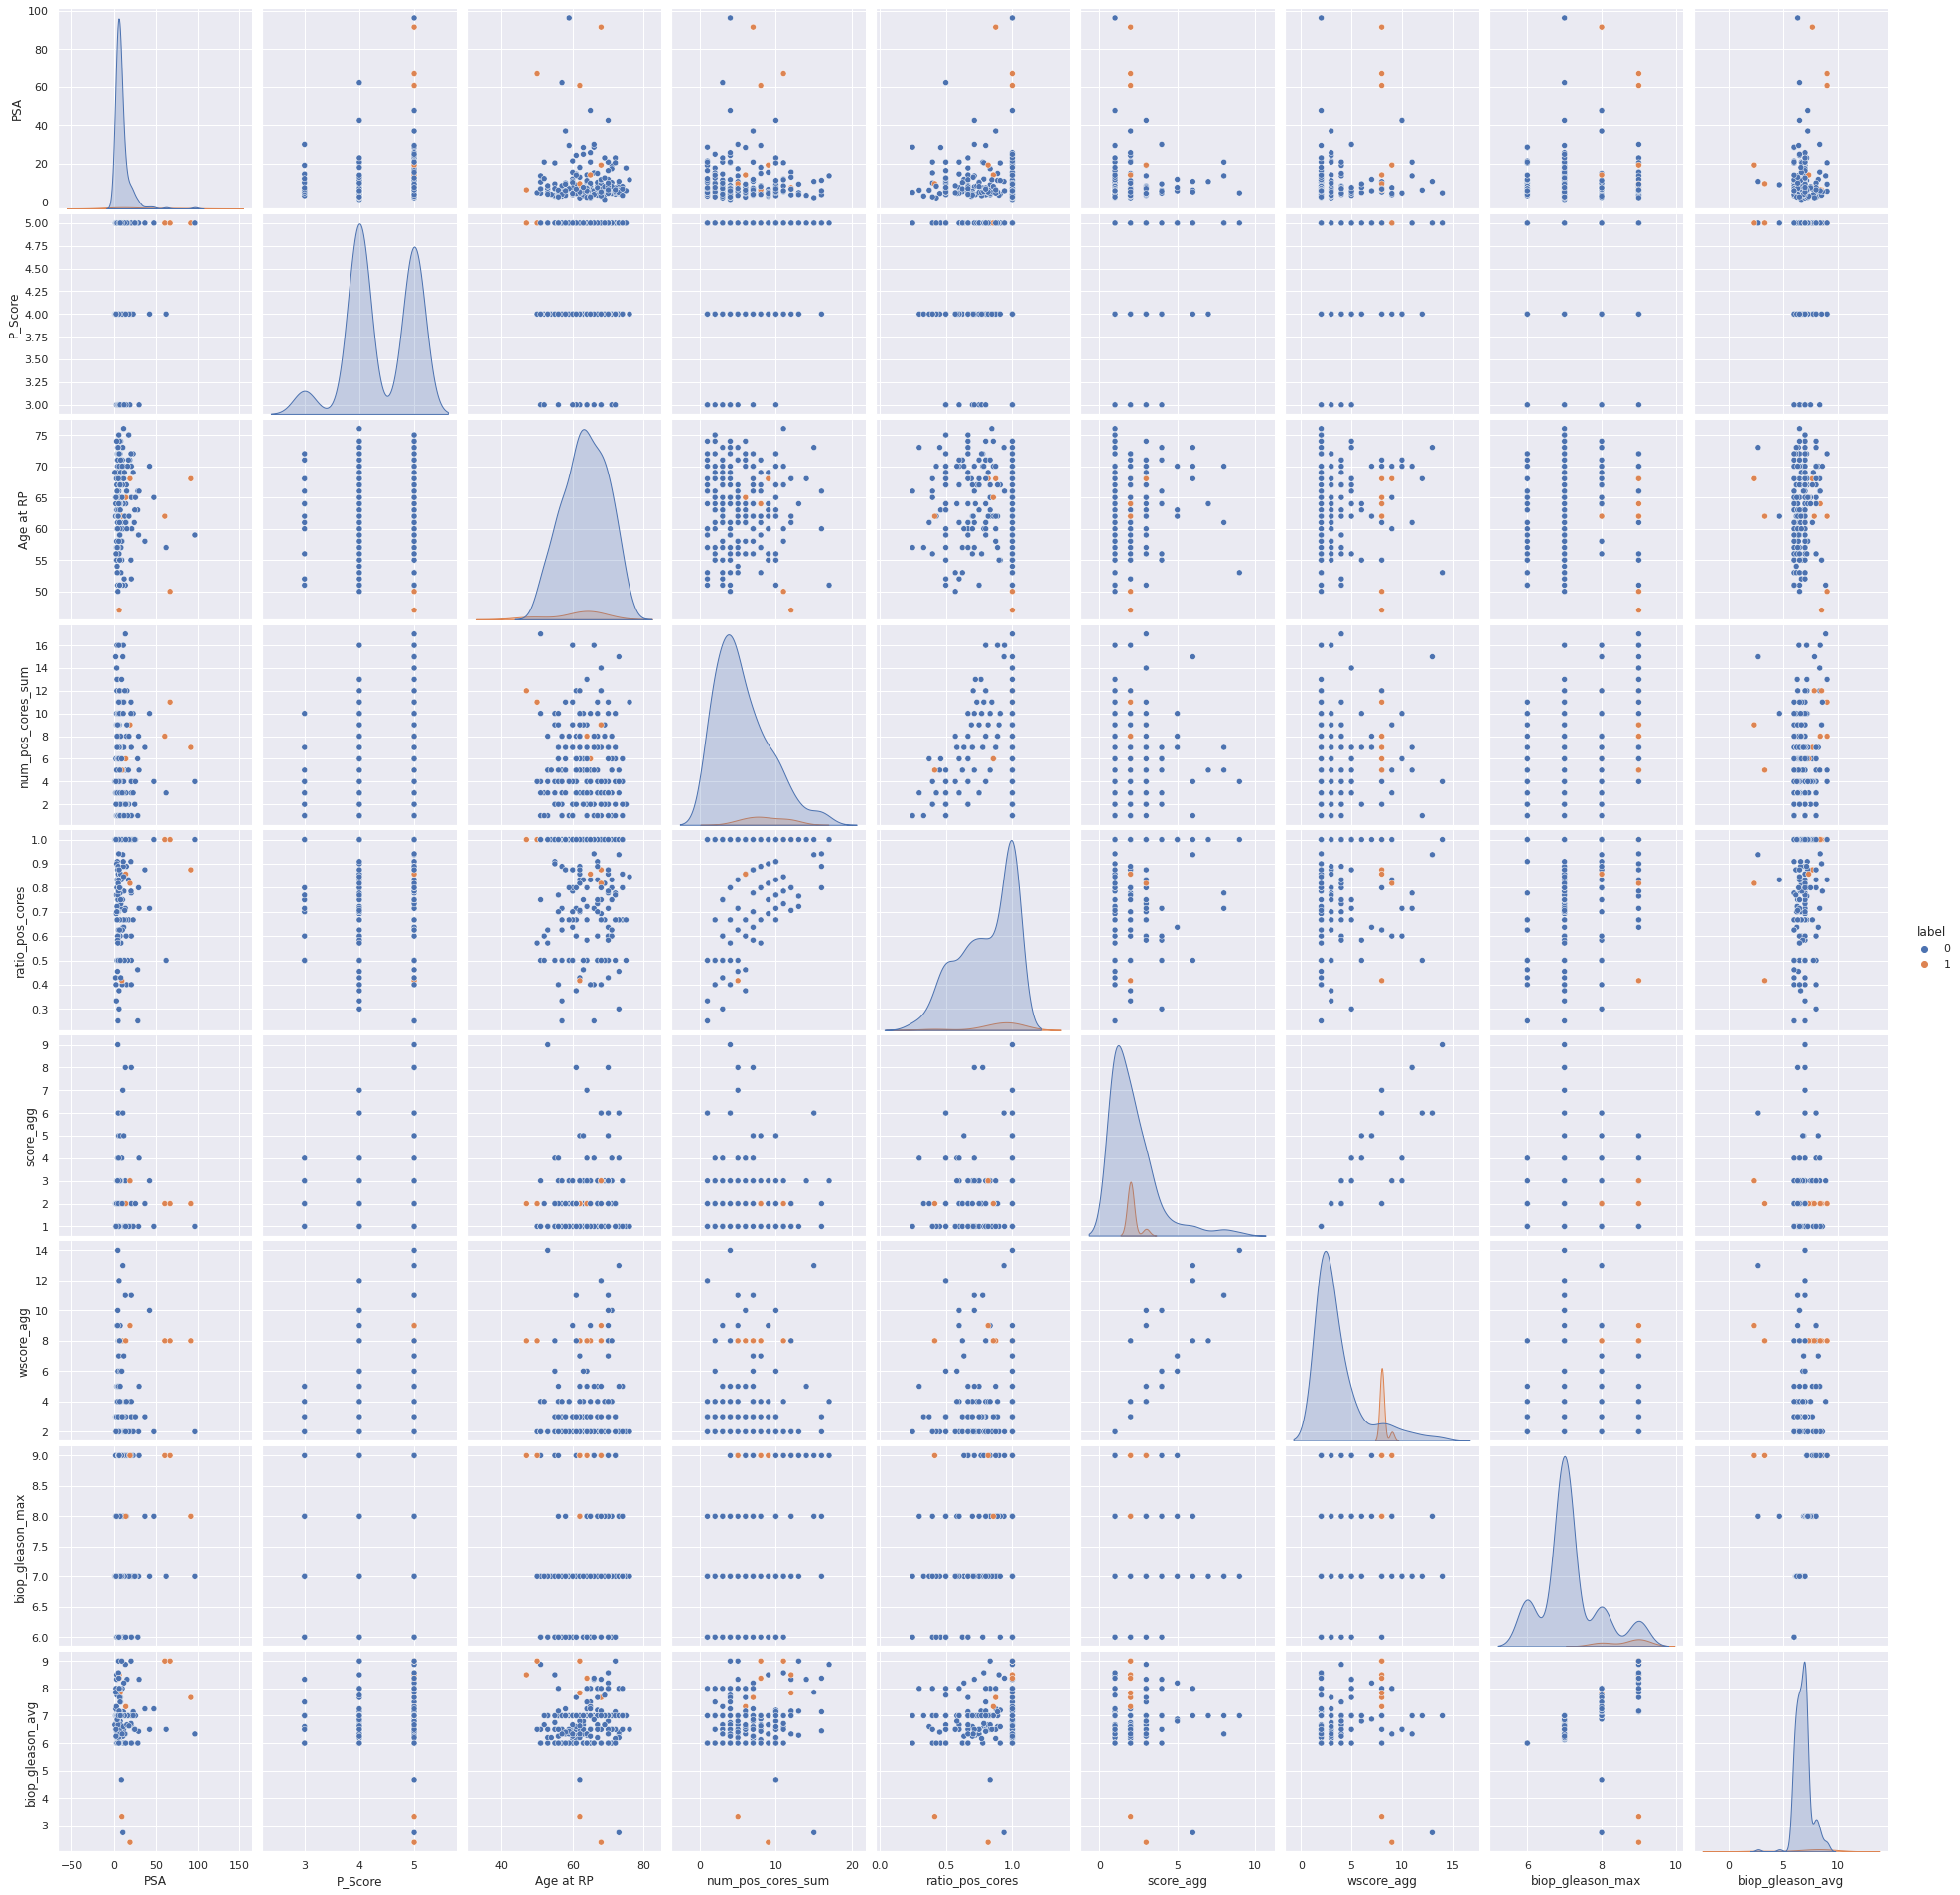

In [183]:
sns.pairplot(Xy, hue="label", height=3)

In [23]:
Xy_filtered = Xy.dropna()
X = Xy_filtered.loc[:, Xy_filtered.columns!='LN_meta']
X = pd.get_dummies(X).values
X.shape

(383, 8)

In [315]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = Xy_filtered['LN_meta'].values
y = encoder.fit_transform(y)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [316]:
y.sum()

16

In [317]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size=0.2, random_state=10)
# 75/25 split so that test set has same number of points in each class (stratified splitting)

In [318]:
y_train.sum(), y_test.sum(), y_train.shape

(13, 3, (306,))

In [319]:
from sklearn.preprocessing import StandardScaler
scale=StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)
#the difference in ranges of features will cause different step sizes for each feature so
#scale data so that gradient descent moves smoothly 

In [320]:
from sklearn.linear_model import LogisticRegression

ovr = LogisticRegression()
ovr.fit(X_train, y_train)
ovr_preds = ovr.predict(X_test)

In [344]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
print(accuracy_score(y_test, ovr_preds))
print(classification_report(y_test, ovr_preds))

0.961038961038961
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        74
           1       0.00      0.00      0.00         3

    accuracy                           0.96        77
   macro avg       0.48      0.50      0.49        77
weighted avg       0.92      0.96      0.94        77



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [345]:
y_test.shape, ovr_pred_prob.shape

((77,), (77, 2))

In [346]:
ovr_pred_prob = ovr.predict_proba(X_test)
roc_auc_score(y_test, ovr_pred_prob[:,1] , average="weighted")
#use auc score as primary metric, since it accounts for varying thresholds
#whereas accuracy is calculated on a the predicted class so it is dependent on
##finding the optimal threshold
#we perform a weighted average of the scores across the classes, but could 
#also do macro as the classes have equal support (test set has an the same numer of 
#points per class)

0.9774774774774775

In [393]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=5, class_weight = {0:1,1:50})
clf.fit(X, y)

RandomForestClassifier(class_weight={0: 1, 1: 100}, max_depth=2, random_state=5)

In [394]:
rf_preds = clf.predict(X_test)
rf_pred_prob = clf.predict_proba(X_test)

In [395]:
print(accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))

0.961038961038961
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        74
           1       0.00      0.00      0.00         3

    accuracy                           0.96        77
   macro avg       0.48      0.50      0.49        77
weighted avg       0.92      0.96      0.94        77



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [396]:
rf_pred_prob = clf.predict_proba(X_test)
roc_auc_score(y_test, rf_pred_prob[:,1] , average="weighted")

0.7567567567567567

## Paper Stats

In [4]:
psas = pd.read_csv('labs_cl.csv')
print(psas.columns)
psa_total = psas[psas["Total PSA"]]
psa_total = psa_total.dropna(subset=['time_lab_result'])

Index(['EMPI', 'time_lab_result', 'lab_group', 'PSA', 'undetect', 'greater',
       'Percent Free', 'Total PSA', 'lab_result', 'lab_result_txt'],
      dtype='object')


In [5]:
singlerp = pd.read_csv('singlerp.csv')
singlerp.shape

(16768, 5)

In [9]:
psas_with_labels = singlerp.merge(psa_total, on="EMPI")
psas_with_labels.EMPI.nunique()

14166

In [11]:
psas_with_labels.columns

Index(['EMPI', 'date_rp', 'hospital_rp', 'lap_rp', 'lymph_rp',
       'time_lab_result', 'lab_group', 'PSA', 'undetect', 'greater',
       'Percent Free', 'Total PSA', 'lab_result', 'lab_result_txt'],
      dtype='object')

In [12]:
psas_with_labels['time_lab_result'] = pd.to_datetime(psas_with_labels.time_lab_result)
psas_with_labels['date'] = pd.to_datetime(psas_with_labels.date_rp)
psas_with_labels['days_diff'] = psas_with_labels['date'] - psas_with_labels['time_lab_result']
psas_with_labels['timely'] = ((psas_with_labels['days_diff']).dt.days > 0) &  ((psas_with_labels['days_diff']).dt.days < 180 )
print("number of patients that don't have PSAs within 180 days of their procedure", psas_with_labels.shape[0] - psas_with_labels["timely"].sum())
valid = psas_with_labels[psas_with_labels['timely']]
print(valid.shape)

number of patients that don't have PSAs within 180 days of their procedure 134578
(10449, 17)


In [13]:
valid.EMPI.nunique()

7685